In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
samp = pd.read_csv('sample_submission.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
train.drop('id', inplace = True, axis = 1)
test.drop('id', inplace = True, axis = 1)

train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
#check missing values

print(train.isnull().sum())
test.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [5]:
# Remove duplicated rows

print(train.duplicated().sum())
train = train.drop_duplicates()
train.shape

0


(165034, 13)

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48
Exited,165034.0,2.115988e-01,0.408443,0.00,0.00,0.0,0.000000e+00,1.00


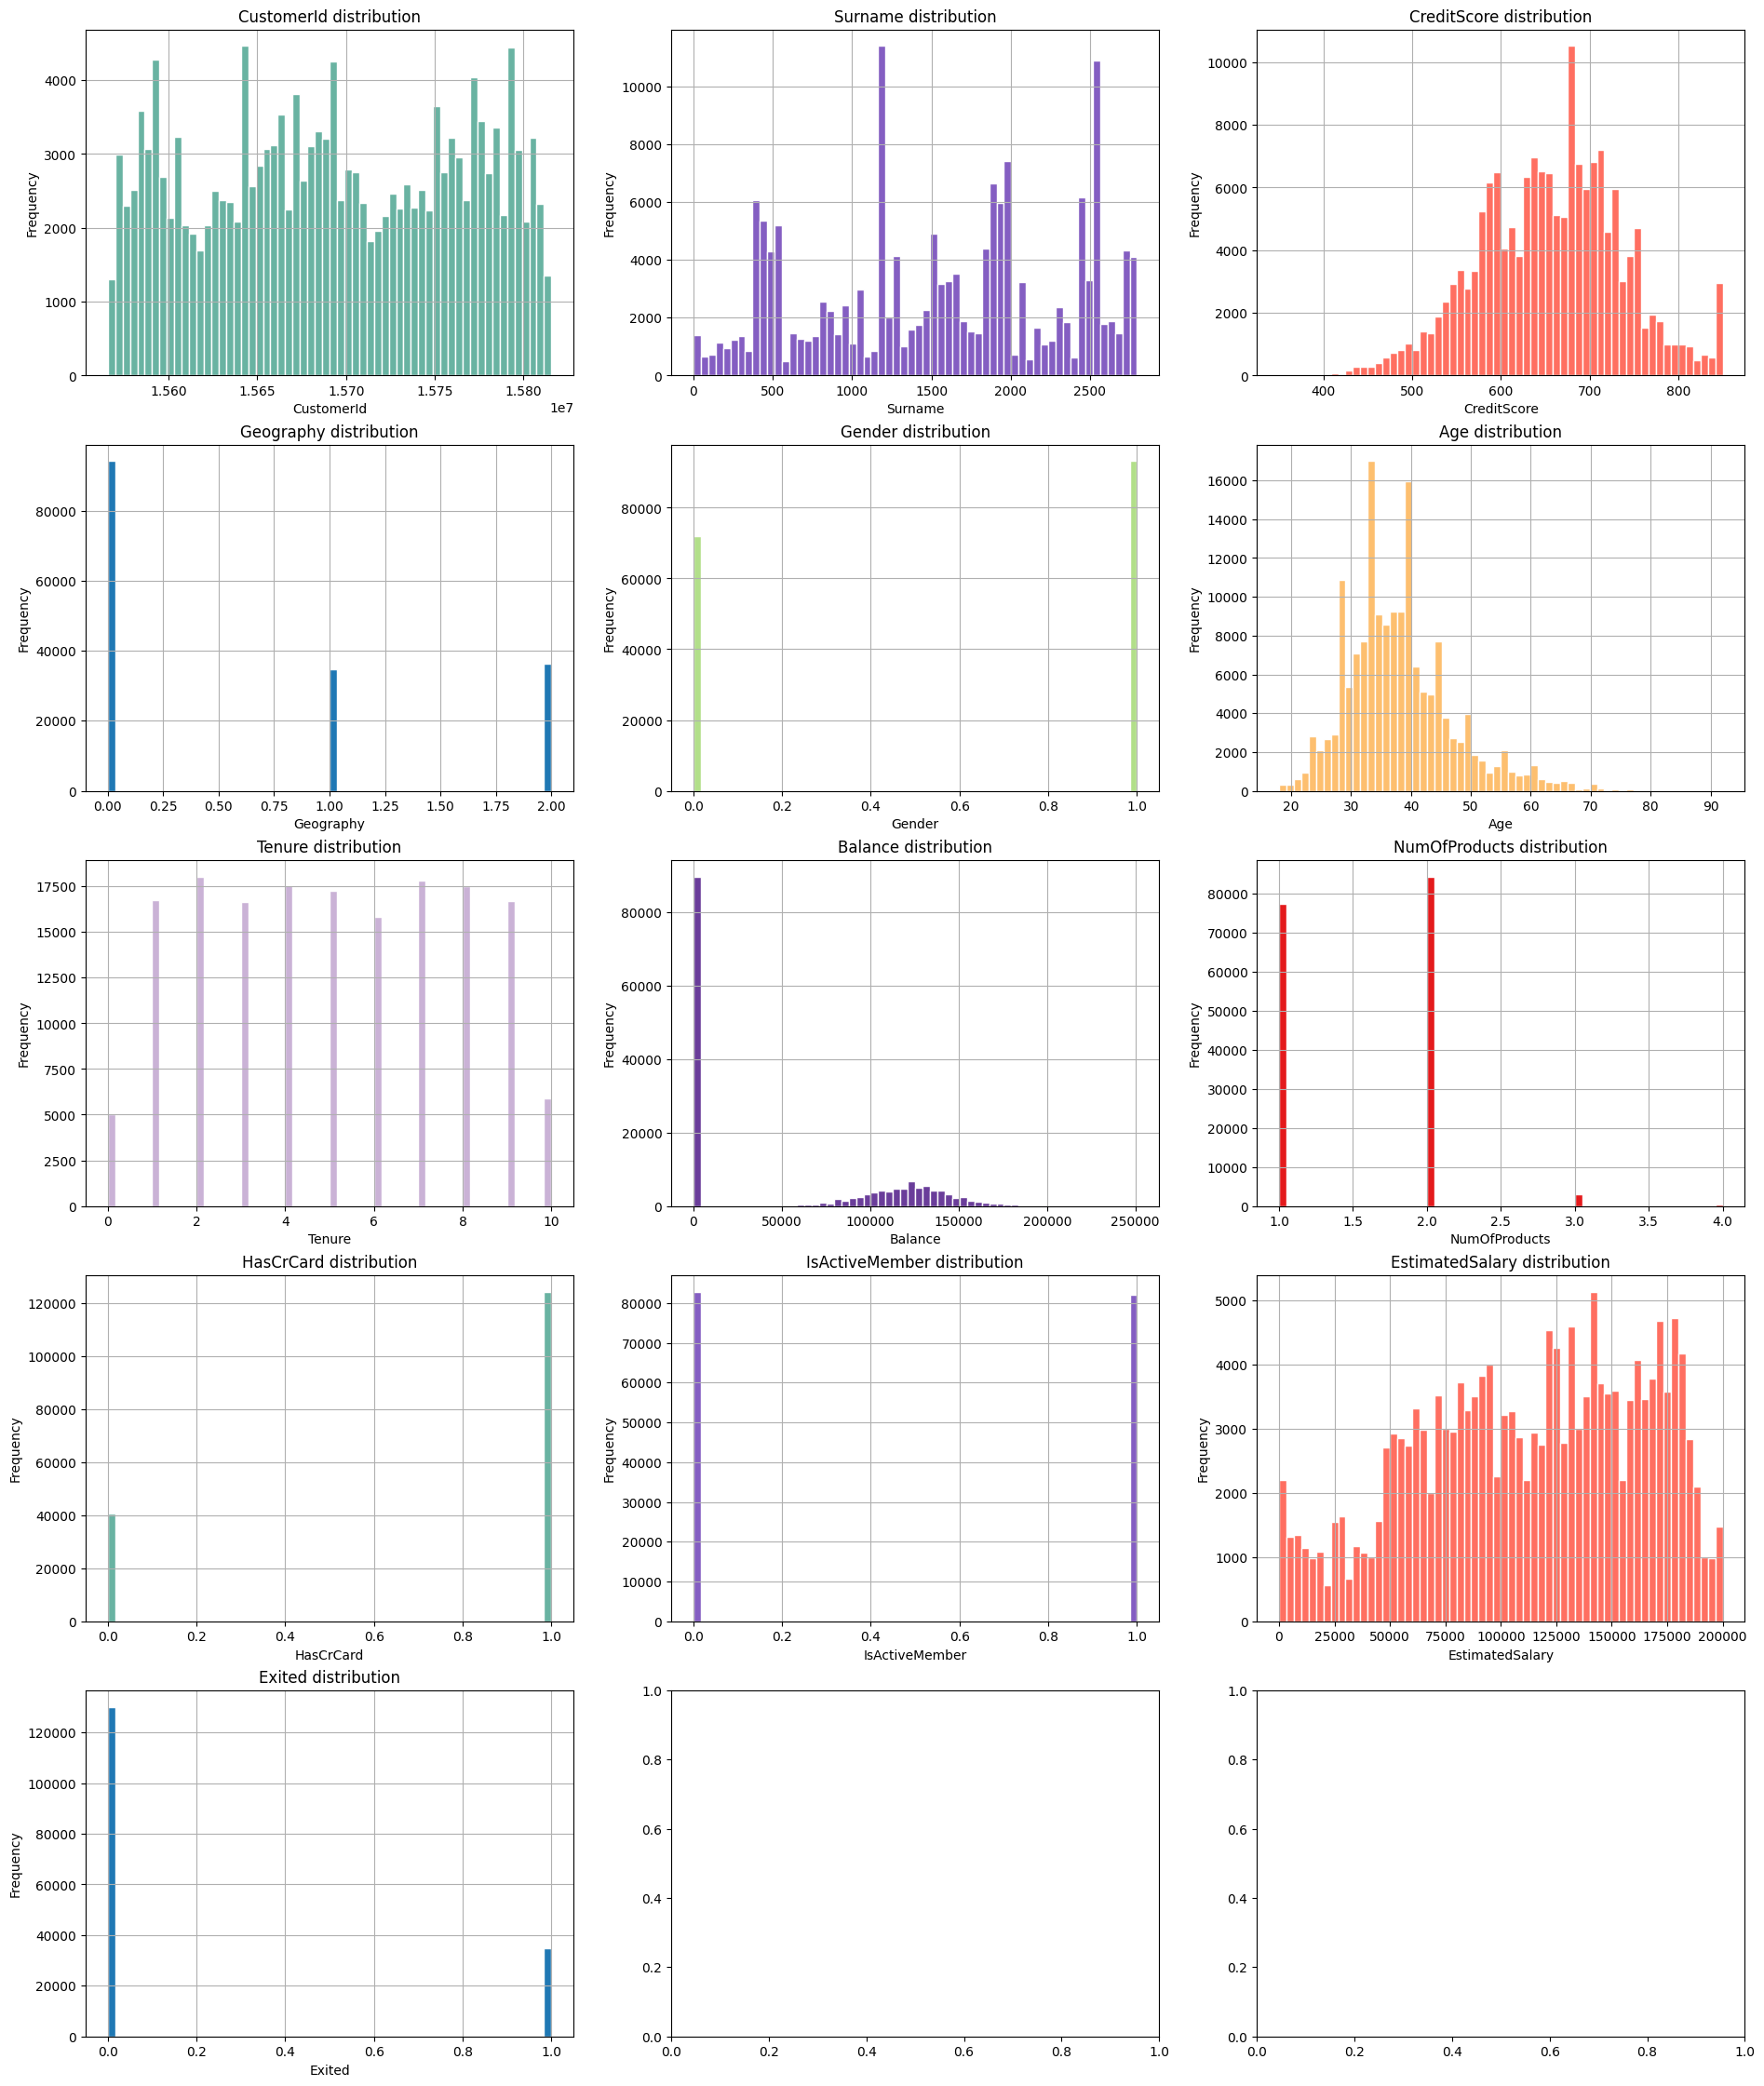

In [34]:
# Plotting every feature on the graph 

from sklearn.preprocessing import LabelEncoder
# Create a deep copy of train and name it data
data = train.copy()

label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Surname'] = label_encoder.fit_transform(data['Surname'])

#data.hist(bins=60, figsize=(17,17), legend = True)

# Get the number of features in your dataset
num_features = len(data.columns)

# Calculate the number of rows and columns for subplots
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(12, 10))
axes = axes.flatten()

color_palette = ['#69b3a2', '#845ec2', '#ff6f61', '#1f78b4', '#b2df8a', '#fdbf6f', '#cab2d6', '#6a3d9a', '#e41a1c']

for i, column in enumerate(data.columns):
    color_index = i % len(color_palette) 
    data[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    color= color_palette[color_index],
                    figsize=(23,28),
                    bins = 60 # Color of the bins
                   )
    
    # Add title and axis label
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
plt.show()